In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

import random
from pathlib import Path
import pandas as pd
import os
# import matplotlib.pyplot as plt
from glob import glob
from hashlib import sha1


In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import HopfieldEstimator
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping


2023-11-08 19:16:58.519559: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 19:16:58.563366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = get_dataset("electricity")

In [4]:
seed = 0
experiment_name = "hopfield"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "hopfield" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]

Using lightning_version version_2 with epoch 46 restoring from checkpoint at path hopfield/0/lightning_logs/version_2/checkpoints/epoch=46-step=4700.ckpt


In [5]:
estimator = HopfieldEstimator(
    # freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*7,
    
    # num_feat_static_cat=1,
    # cardinality=[321],
    # embedding_dimension=[3],
    dim_feedforward=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    activation="relu",

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1, logger=logger, callbacks=callbacks),
    ckpt_path = ckpt_path
)

In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.test,
    shuffle_buffer_length=1024,
    ckpt_path = ckpt_path
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at hopfield/0/lightning_logs/version_2/checkpoints/epoch=46-step=4700.ckpt
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:338: UserWarning: The dirpath has changed from 'hopfield/0/lightning_logs/version_2/checkpoints' to 'hopfield/0/lightning_logs/version_3/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | HopfieldModel | 125 K 
----------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.504     Total 

Sanity Checking: 0it [00:00, ?it/s]

Training: 100it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' reached 4.87100 (best 4.87100), saving model to 'hopfield/0/lightning_logs/version_3/checkpoints/epoch=47-step=4800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' reached 4.82884 (best 4.82884), saving model to 'hopfield/0/lightning_logs/version_3/checkpoints/epoch=48-step=4900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' reached 4.80664 (best 4.80664), saving model to 'hopfield/0/lightning_logs/version_3/checkpoints/epoch=49-step=5000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 7770.28it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [11]:
agg_metrics

{'MSE': 1638877.6346767517,
 'abs_error': 7708668.963669509,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6640064182106057,
 'MAPE': 0.08697222426196119,
 'sMAPE': 0.0966050166980995,
 'MSIS': 5.394288801893963,
 'QuantileLoss[0.1]': 3684872.672314029,
 'Coverage[0.1]': 0.06896232013054442,
 'QuantileLoss[0.2]': 5608890.227113688,
 'Coverage[0.2]': 0.15665331553182021,
 'QuantileLoss[0.3]': 6824374.3905562945,
 'Coverage[0.3]': 0.2553404539385848,
 'QuantileLoss[0.4]': 7495151.78610779,
 'Coverage[0.4]': 0.3583110814419226,
 'QuantileLoss[0.5]': 7708668.990320951,
 'Coverage[0.5]': 0.464508233199822,
 'QuantileLoss[0.6]': 7476877.498982693,
 'Coverage[0.6]': 0.5627317905355288,
 'QuantileLoss[0.7]': 6769850.03663014,
 'Coverage[0.7]': 0.6725634178905207,
 'QuantileLoss[0.8]': 5568779.227312643,
 'Coverage[0.8]': 0.7828771695594126,
 'QuantileLoss[0.9]': 3738270.534303218,
 'Coverage[0.9]': 0.8894451861741581,
 

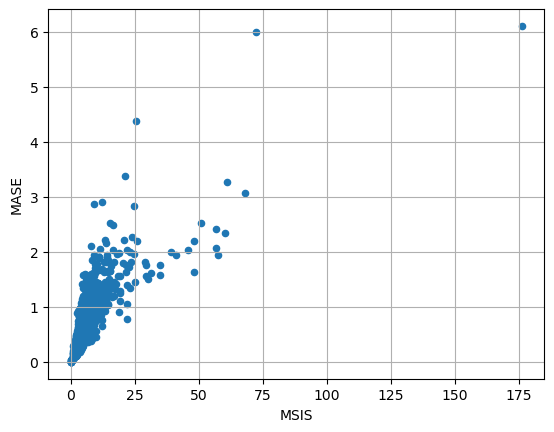

In [12]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

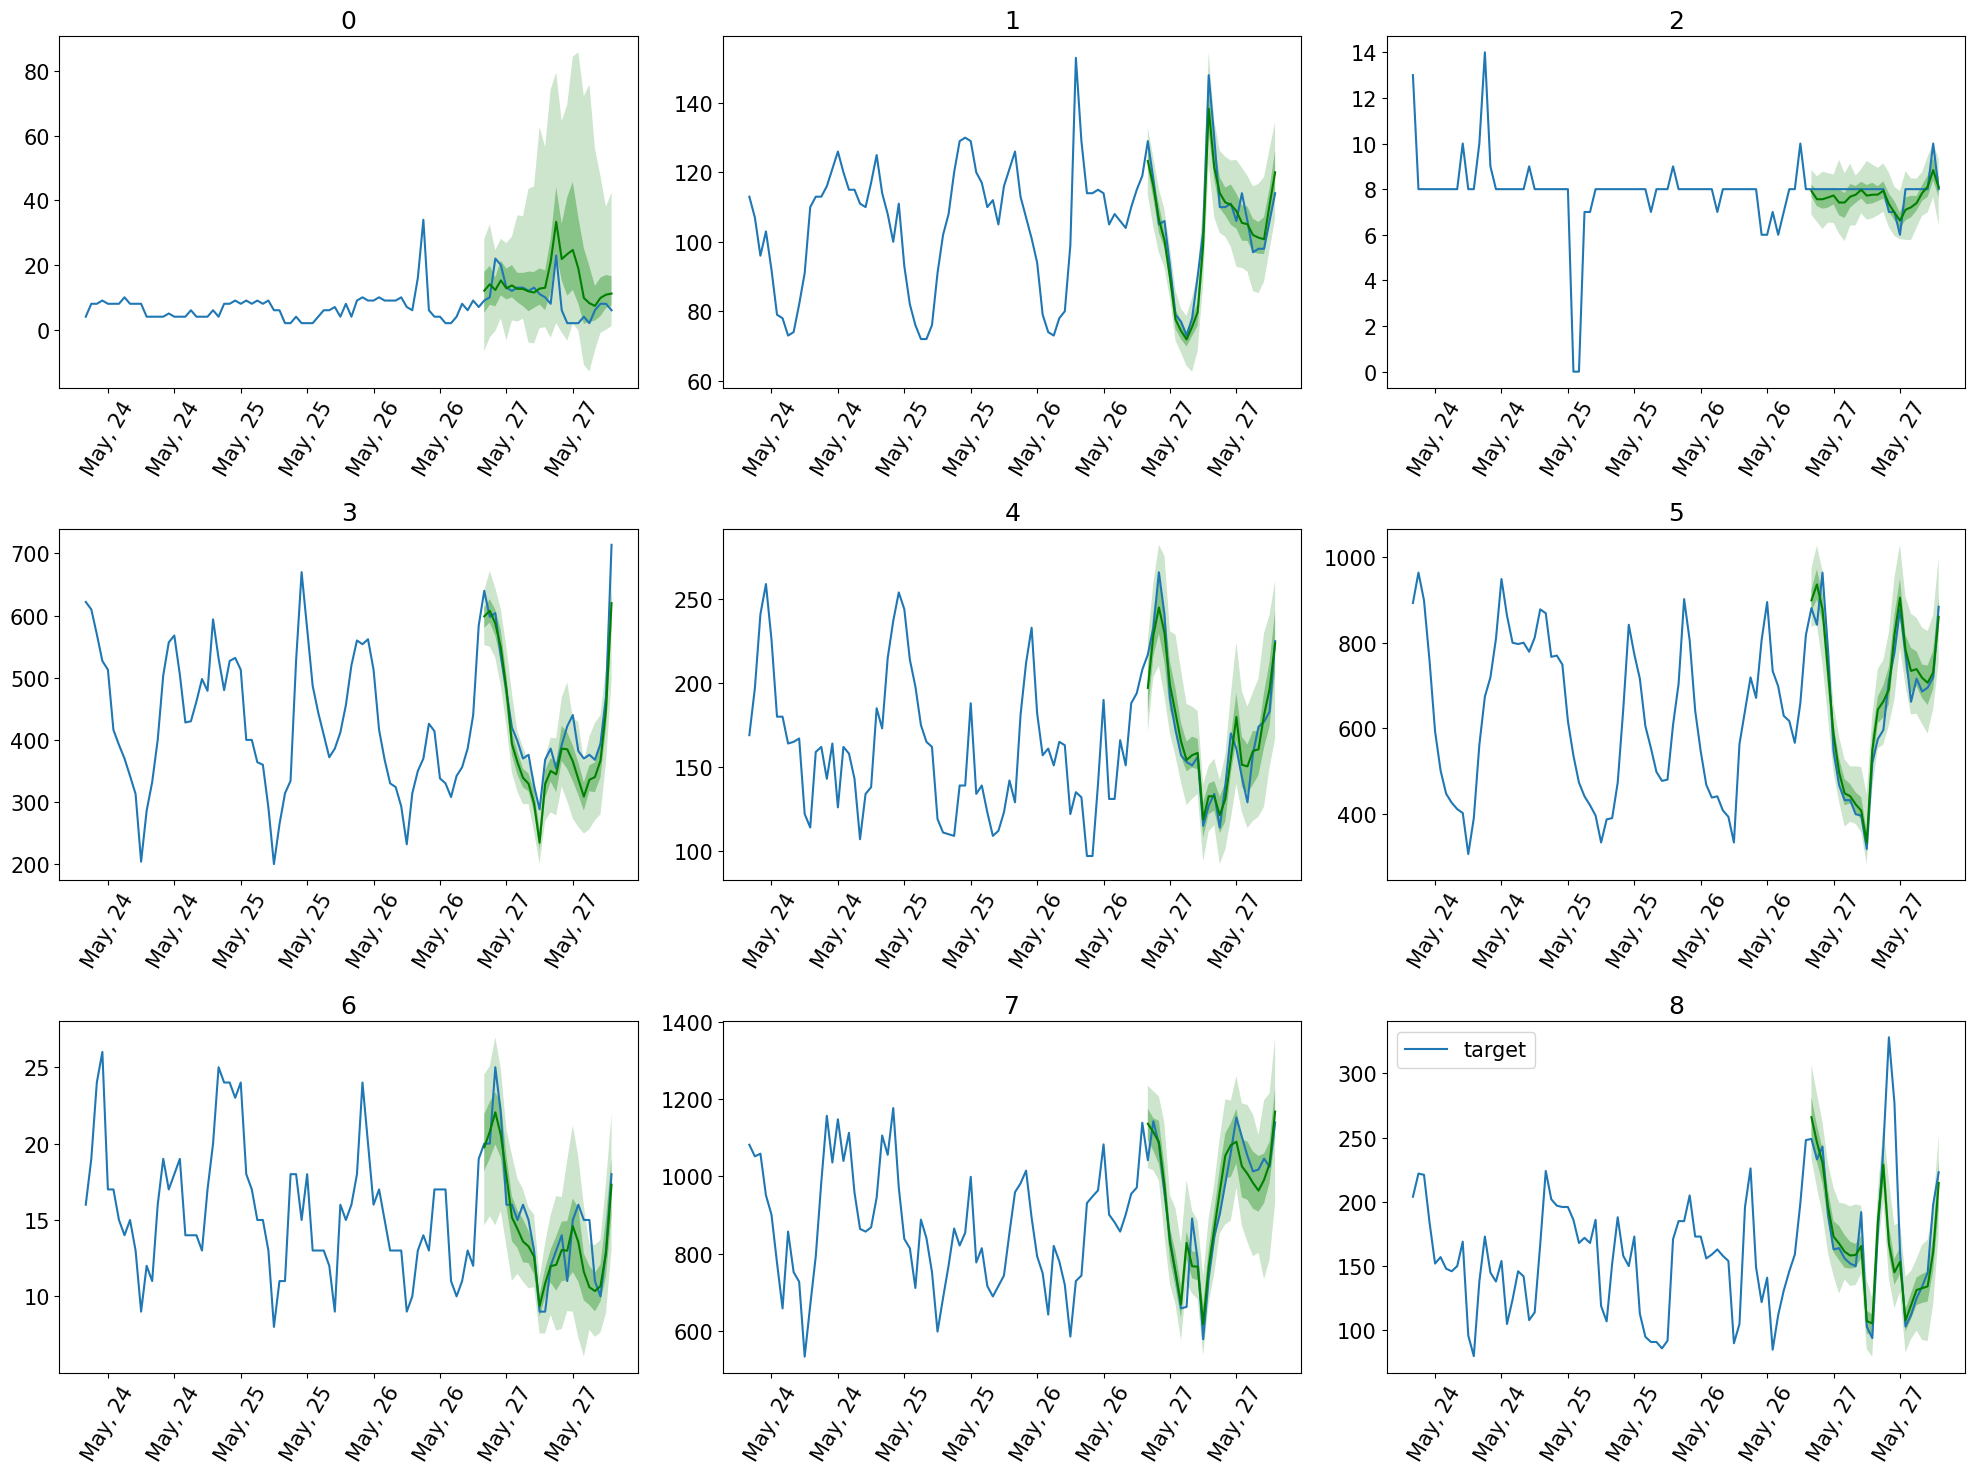

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length :].to_timestamp()

    plt.plot(
        ts[-4 * dataset.metadata.prediction_length :],
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()